# **Avalanche Risk Project**

Advanced Data Analytics, Fall 2025

The following project examines the feasibility of deep learning models (3D-CNN, convLSTM) compared to traditional, state-of-the-art methods for predicting avalanche danger levels. Using a comprehensive dataset from the Swiss Federal Institute for Snow and Avalanche Research (SLF) spanning from 1997-2020, the project heavily relies on the work of Pérez-Guillén et al. (2022) and Maissen et al. (2024) and adopts many of their preprocessing and modeling techniques.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Check if running on Kaggle
is_kaggle = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if is_kaggle:
    # Kaggle paths
    CLEANED_DATA_PATH = '/kaggle/input/avalanche/data/cleaned_data.parquet'
    grid_dir = '/kaggle/input/avalanche/data/grids'
    
    # Kaggle Output Paths (Writable)
    output_dir = '/kaggle/working'
    model_save_dir = os.path.join(output_dir, 'models')
    
    # Install necessary packages
    print("Running on Kaggle - Installing packages...")
    import subprocess
    subprocess.run(['pip', 'install', '-q', 'xarray-spatial', 'rasterio', 'geopandas'], check=True)
else:
    # Local Paths
    CLEANED_DATA_PATH = '../data/cleaned_data.parquet'
    grid_dir = '../data/grids'
    
    output_dir = 'results'
    model_save_dir = 'models'
    
    print("Running Locally. Standard paths used.")

# Define grid subdirectories
dynamic_dir = os.path.join(grid_dir, 'dynamic')
target_dir = os.path.join(grid_dir, 'targets')
static_file = os.path.join(grid_dir, 'static_terrain.npy')

# Create output directories if they don't exist (critical for Kaggle)
os.makedirs(model_save_dir, exist_ok=True)

print(f"Data path: {CLEANED_DATA_PATH}")
print(f"Grid directory: {grid_dir}")
print(f"Model save directory: {model_save_dir}")

Running on Kaggle - Installing packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 90.8 MB/s eta 0:00:00
Data path: /kaggle/input/avalanche/data/cleaned_data.parquet
Grid directory: /kaggle/input/avalanche/data/grids
Model save directory: /kaggle/working/models


## **5.1 Model Initialization**

In [3]:
# Features
dynamic_features = [
    'delta_elevation',    
    'Pen_depth',          
    'HN24',               
    'MS_Snow',            
    'TA',                 
    'wind_trans24',       
    'RH',                 
    'min_ccl_pen',        
    'relative_load_3d',   
    'wind_u',             
    'wind_v'              
]

In [4]:
# Verify Shape
files = sorted(os.listdir('/kaggle/input/avalanche/data/grids/dynamic'))
first_file = os.path.join('/kaggle/input/avalanche/data/grids/dynamic', files[0])
data = np.load(first_file)['data']

print(f"REAL Shape on Disk: {data.shape}")
print(f"Number of Channels: {data.shape[-1]}")

REAL Shape on Disk: (211, 470, 11)
Number of Channels: 11


In [5]:
# Load Data
print("Loading data...")
df = pd.read_parquet(CLEANED_DATA_PATH)

# Re-calculate Wind Vectors
if 'DW' in df.columns and 'VW' in df.columns:
    wd_rad = np.deg2rad(df['DW'])
    df['wind_u'] = -df['VW'] * np.sin(wd_rad)
    df['wind_v'] = -df['VW'] * np.cos(wd_rad)
    print("Wind vectors calculated.")

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Columns available: {df.columns.tolist()[:10]}...")  # Show first 10 columns

Loading data...
Wind vectors calculated.
Dataset loaded: 291535 rows, 64 columns
Columns available: ['datum', 'station_code', 'sector_id', 'warnreg', 'elevation_station', 'forecast_initial_date', 'forecast_end_date', 'dangerLevel', 'elevation_th', 'set']...


In [6]:
# Data Splitting (Train/Val/Test) 
test_dates = df[df['set'] == 'test']['datum'].unique().astype(str)

# Split training data by full winter seasons
# Validation: Winters 2016/17 and 2017/18
df_train = df[df['set'] == 'train'].copy()
df_train['datum'] = pd.to_datetime(df_train['datum'])
val_mask = (
    ((df_train['datum'] >= '2016-11-01') & (df_train['datum'] <= '2017-04-30')) |
    ((df_train['datum'] >= '2017-11-01') & (df_train['datum'] <= '2018-04-30'))
)
val_dates = df_train[val_mask]['datum'].unique().astype(str)
train_dates = df_train[~val_mask]['datum'].unique().astype(str)

print(f"Train Days: {len(train_dates)} | Val Days: {len(val_dates)} | Test Days: {len(test_dates)}")
print(f"  Train range: {pd.to_datetime(train_dates).min()} to {pd.to_datetime(train_dates).max()}")
print(f"  Val winters: 2016/17 and 2017/18")
print(f"  Val range: {pd.to_datetime(val_dates).min()} to {pd.to_datetime(val_dates).max()}")
print(f"  Test range: {test_dates[0]} to {test_dates[-1]}")

# Normalization
train_df_subset = df[df['datum'].astype(str).isin(train_dates)]

stats = {col: {
    'mean': train_df_subset[col].mean(), 
    'std': train_df_subset[col].std()
} for col in dynamic_features}

Train Days: 3132 | Val Days: 328 | Test Days: 359
  Train range: 1997-11-12 00:00:00 to 2017-05-08 00:00:00
  Val winters: 2016/17 and 2017/18
  Val range: 2016-11-09 00:00:00 to 2018-04-14 00:00:00
  Test range: 2019-11-16 to 2019-04-24


In [7]:
# Hyperparameters 
batch_size = 4        # Kaggle T4 can handle 4-8, start with 4
learning_rate = 1e-4
epochs = 10
lookback = 7          # T-6 to T
num_classes = 5       # 0=NoData (Ignore), 1, 2, 3, 4 (High)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Running on device: {device}")
print(f"Batch size: {batch_size}")
print(f"Grid paths configured:")
print(f"  Dynamic: {dynamic_dir}")
print(f"  Target: {target_dir}")
print(f"  Static: {static_file}")

Running on device: cuda
Batch size: 4
Grid paths configured:
  Dynamic: /kaggle/input/avalanche/data/grids/dynamic
  Target: /kaggle/input/avalanche/data/grids/targets
  Static: /kaggle/input/avalanche/data/grids/static_terrain.npy


In [8]:
class AvalancheDataset(Dataset):
    def __init__(self, date_list, feature_dir, target_dir, static_file, stats, feature_names, lookback=7):
        self.dates = date_list
        self.feature_dir = feature_dir
        self.target_dir = target_dir
        self.stats = stats
        self.feature_names = feature_names
        self.lookback = lookback
        
        # Load static data 
        self.static_data = np.load(static_file).astype(np.float32)
        if np.max(self.static_data) > 5.0: # Heuristic check
            print("Raw Static Data detected. Normalizing to [0,1] range...")
            # Min-Max Normalization per channel
            # shape is (H, W, C) -> normalize over (0, 1) spatial dims
            min_val = np.min(self.static_data, axis=(0, 1), keepdims=True)
            max_val = np.max(self.static_data, axis=(0, 1), keepdims=True)
            # Avoid divide by zero
            self.static_data = (self.static_data - min_val) / (max_val - min_val + 1e-6)
        
        # Define expected shape
        self.expected_h = self.static_data.shape[0]
        self.expected_w = self.static_data.shape[1]
        self.expected_c = len(self.feature_names)
        
        print(f"Dataset initialized. Expecting Shape: ({self.expected_h}, {self.expected_w}, {self.expected_c})")

    def __len__(self):
        return len(self.dates)

    def __getitem__(self, idx):
        target_date_str = self.dates[idx]
        target_date = pd.to_datetime(target_date_str)
        
        # 1. Build Dynamic Sequence
        frames = []
        start_date = target_date - pd.Timedelta(days=self.lookback - 1)
        
        for i in range(self.lookback):
            d_str = (start_date + pd.Timedelta(days=i)).strftime('%Y-%m-%d')
            f_path = os.path.join(self.feature_dir, f"{d_str}.npz")
            
            if os.path.exists(f_path):
                raw = np.load(f_path)['data']
                norm_data = raw 
                frames.append(norm_data)
            else:
                shape = (self.expected_h, self.expected_w, self.expected_c)
                frames.append(np.zeros(shape, dtype=np.float32))
        
        # Check shape before stacking
        shapes = [f.shape for f in frames]
        if not all(s == shapes[0] for s in shapes):
            print(f"\nCrash detected at Date: {target_date}")
            print(f"Indices in batch: {shapes}")
            print(f"Notebook expects: {self.expected_c} channels")
            raise ValueError(f"Shape Mismatch! See print above.")
            
        # Stack Time
        dynamic_tensor = np.stack(frames, axis=0)
        
        # Static Data
        static_expanded = np.tile(self.static_data[np.newaxis, ...], (self.lookback, 1, 1, 1))
        full_cube = np.concatenate([dynamic_tensor, static_expanded], axis=-1)
        
        # Load Target
        target_path = os.path.join(self.target_dir, f"{target_date_str}.npy")
        if os.path.exists(target_path):
            label = np.load(target_path).astype(np.int64)
            label[label == -1] = 0
            
            # Verify Target Shape
            if label.shape != (self.expected_h, self.expected_w):
                label = np.zeros((self.expected_h, self.expected_w), dtype=np.int64)
        else:
            label = np.zeros((self.expected_h, self.expected_w), dtype=np.int64)

        # Permute to (C, T, H, W)
        X = torch.from_numpy(full_cube).permute(3, 0, 1, 2)
        Y = torch.from_numpy(label)
        
        return X, Y

We test 3 distinct architectures:

- DeepAvalancheNet (The Baseline)
  Type: Deep 3D CNN (4 Layers)
  Structure: 32 $\to$ 64 $\to$ 128 $\to$ 256 filters with MaxPooling.
  Why: Acts as a strong, general-purpose feature extractor that learns spatio-temporal patterns simultaneously. It serves as the standard to beat.

- DilatedAvalancheNet (Spatial Specialist)
  Type: 3D CNN with Dilated ConvolutionsStructure: Same backbone as Baseline, but uses dilation=2     in the deeper layers.
  Why: Increases the Receptive Field without reducing resolution or adding parameters. This helps     the model "see" broader regional contexts (like wind-loading effects from neighboring valleys)      that a standard CNN might miss.


- AvalancheConvLSTM (Temporal Specialist)
  Type: Hybrid CNN-RNNStructure: Spatial Encoder $\to$ Convolutional LSTM Memory Cell.
  Why: Explicitly models the sequence of weather events. Unlike a 3D CNN (which treats the week as    a block), the LSTM understands the order of events (e.g., a massive storm followed by a warm day    vs. a warm day followed by a storm).

In [9]:
# Assuming num_classes=5 and in_channels=len(FEATURE_NAMES)+4

# 1. DeepAvalancheNet (Baseline)
class DeepAvalancheNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DeepAvalancheNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv3d(in_channels, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU(), nn.Dropout3d(0.2))
        self.layer2 = nn.Sequential(nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(), nn.MaxPool3d((1, 2, 2)), nn.Dropout3d(0.2))
        self.layer3 = nn.Sequential(nn.Conv3d(64, 128, 3, padding=1), nn.BatchNorm3d(128), nn.ReLU(), nn.Dropout3d(0.3))
        self.layer4 = nn.Sequential(nn.Conv3d(128, 256, 3, padding=1), nn.BatchNorm3d(256), nn.ReLU(), nn.MaxPool3d((1, 2, 2)), nn.Dropout3d(0.3))
        self.pool = nn.AdaptiveAvgPool3d((1, None, None))
        # Removed fixed self.upsample

        self.final = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        # Capture original spatial dimensions (Height, Width)
        # x shape: (Batch, Channels, Time, Height, Width)
        orig_size = (x.shape[3], x.shape[4]) 
        
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        
        # Collapse Time
        x = self.pool(x).squeeze(2)
        
        # Dynamic Upsampling: Force exact match to input H,W
        x = F.interpolate(x, size=orig_size, mode='bilinear', align_corners=True)
        
        return self.final(x)

# Dilated CNN
class DilatedAvalancheNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DilatedAvalancheNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv3d(in_channels, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(), nn.MaxPool3d((1, 2, 2)))
        
        # Dilation = 2
        self.layer3 = nn.Sequential(nn.Conv3d(64, 128, 3, padding=2, dilation=2), nn.BatchNorm3d(128), nn.ReLU(), nn.Dropout3d(0.3))
        
        # FIX IS HERE: padding=(0, 1, 1) prevents padding on the Time dimension (dim 0)
        self.layer4 = nn.Sequential(
            nn.Conv3d(128, 256, 3, padding=2, dilation=2), 
            nn.BatchNorm3d(256), 
            nn.ReLU(), 
            nn.MaxPool3d((1, 2, 2), padding=(0, 1, 1)), 
            nn.Dropout3d(0.3)
        )
        self.pool = nn.AdaptiveAvgPool3d((1, None, None))
        self.final = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        orig_size = (x.shape[3], x.shape[4])
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.pool(x).squeeze(2)
        x = F.interpolate(x, size=orig_size, mode='bilinear', align_corners=True)
        return self.final(x)

class AvalancheConvLSTM(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_dim=64):
        super(AvalancheConvLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, hidden_dim, 3, padding=1), nn.ReLU()
        )
        self.lstm_gate = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 3, padding=1)
        self.final = nn.Conv2d(hidden_dim, num_classes, 1)

    def forward(self, x):
        b, c, t, h, w = x.size()
        x_flat = x.permute(0, 2, 1, 3, 4).reshape(b * t, c, h, w)
        feats = self.conv(x_flat).view(b, t, self.hidden_dim, h, w)
        ht = torch.zeros(b, self.hidden_dim, h, w).to(x.device)
        ct = torch.zeros(b, self.hidden_dim, h, w).to(x.device)
        for i in range(t):
            combined = torch.cat([feats[:, i], ht], dim=1)
            gates = self.lstm_gate(combined)
            i_gate, f_gate, c_gate, o_gate = gates.chunk(4, 1)
            ct = torch.sigmoid(f_gate) * ct + torch.sigmoid(i_gate) * torch.tanh(c_gate)
            ht = torch.sigmoid(o_gate) * torch.tanh(ct)
        return self.final(ht)
        
# For final evaluation 
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, ignore_index=0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.ce = nn.CrossEntropyLoss(weight=alpha, ignore_index=ignore_index, reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [10]:
def calculate_metrics(model, dataloader, device, criterion):
    """
    Calculate validation metrics including Macro-F1 score.
    
    Returns:
        dict: Contains loss, macro_f1, and per-class F1 scores
    """
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            
            # Get predictions (argmax over class dimension)
            preds = torch.argmax(outputs, dim=1)
            
            # Flatten spatial dimensions and filter out ignore_index (0)
            preds_flat = preds.cpu().numpy().flatten()
            targets_flat = y.cpu().numpy().flatten()
            
            # Only keep non-zero labels (ignore background)
            mask = targets_flat != 0
            preds_flat = preds_flat[mask]
            targets_flat = targets_flat[mask]
            
            all_preds.extend(preds_flat)
            all_targets.extend(targets_flat)
    
    avg_loss = total_loss / len(dataloader)
    
    # Calculate Macro-F1 (average F1 across classes 1-4)
    macro_f1 = f1_score(all_targets, all_preds, average='macro', labels=[1, 2, 3, 4], zero_division=0)
    
    # Per-class F1 scores
    per_class_f1 = f1_score(all_targets, all_preds, average=None, labels=[1, 2, 3, 4], zero_division=0)
    
    return {
        'loss': avg_loss,
        'macro_f1': macro_f1,
        'f1_class_1': per_class_f1[0],
        'f1_class_2': per_class_f1[1],
        'f1_class_3': per_class_f1[2],
        'f1_class_4': per_class_f1[3]
    }

In [11]:
# 1. Print class distribution & Calculate Weights
freq_dangerLevel = train_df_subset['dangerLevel'].value_counts(normalize=True).sort_index()
print(f"Class Distribution in Training Data:\n{freq_dangerLevel}\n")
    
# Calculate weights based on training labels
y_train_labels = train_df_subset['dangerLevel'].values.astype(int)
classes = np.unique(y_train_labels)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_labels)
    
# Convert to Tensor (Index 0 is 'No Data', mapped to weight 0)
# Classes in data are 1, 2, 3, 4. Indices in tensor are 0, 1, 2, 3, 4.
final_weights = torch.tensor([0.0] + list(weights), dtype=torch.float32)
    
print(f"Class Weights (balanced): {final_weights}")

# 2. Instantiate Datasets
train_ds = AvalancheDataset(train_dates, dynamic_dir, target_dir, static_file, stats, dynamic_features)
val_ds = AvalancheDataset(val_dates, dynamic_dir, target_dir, static_file, stats, dynamic_features)

# 3. Instantiate DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, 
                          num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True, persistent_workers=True)

print("\nDataLoaders and Weighted Loss Function ready.")

Class Distribution in Training Data:
dangerLevel
1.0    0.197577
2.0    0.422466
3.0    0.364264
4.0    0.015694
Name: proportion, dtype: float64

Class Weights (balanced): tensor([ 0.0000,  1.2653,  0.5918,  0.6863, 15.9299])
Dataset initialized. Expecting Shape: (211, 470, 11)
Dataset initialized. Expecting Shape: (211, 470, 11)

DataLoaders and Weighted Loss Function ready.


## **5.2 Architecture Search**

This training loop includes:
- **Checkpoint saving/resuming**: Prevents data loss from crashes
- **Macro-F1 tracking**: Primary metric for imbalanced data
- **Early stopping**: Stops when validation performance plateaus
- **Mixed precision**: Faster training on GPU

In [12]:
def train_model_engine(model_name, model, train_loader, val_loader, criterion, epochs=10, patience=3):
    print(f"\n{'='*70}")
    print(f"Training: {model_name}")
    print(f"{'='*70}")
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=patience)
    scaler = GradScaler()
    
    # Best metrics tracking
    best_f1 = 0.0
    best_dl4 = 0.0
    best_val_loss = float('inf')
    
    # History tracking
    history = {'train_losses': [], 'val_losses': [], 'val_macro_f1s': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        # 1. Training Loop
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for X, Y in loop:
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            with autocast():
                out = model(X)
                loss = criterion(out, Y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            
            # Update progress bar with live training loss
            loop.set_postfix(train_loss=loss.item())
            
        avg_train_loss = train_loss / len(train_loader)
            
        # 2. Validation Loop
        model.eval()
        val_loss_accum = 0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                out = model(X)
                loss = criterion(out, Y)
                val_loss_accum += loss.item()
                
                pred = torch.argmax(out, dim=1)
                mask = Y != 0 
                val_preds.append(pred[mask].cpu())
                val_targets.append(Y[mask].cpu())
        
        avg_val_loss = val_loss_accum / len(val_loader)
        all_p = torch.cat(val_preds).numpy()
        all_t = torch.cat(val_targets).numpy()
        
        # 3. Metrics Calculation
        f1 = f1_score(all_t, all_p, average='macro')
        recalls = recall_score(all_t, all_p, average=None, labels=[1,2,3,4])
        # Safe recall extraction (handle missing classes)
        dl4_recall = recalls[3] if len(recalls) >= 4 else 0.0
        
        # Log History
        history['train_losses'].append(avg_train_loss)
        history['val_losses'].append(avg_val_loss)
        history['val_macro_f1s'].append(f1)
        
        # Print Epoch Stats
        print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f} | Val Loss {avg_val_loss:.4f} | F1 {f1:.4f} | DL4 Recall {dl4_recall:.4f}")
        
        # Update Scheduler
        scheduler.step(f1)
        
        # 4. Save Best Model
        if f1 > best_f1:
            best_f1 = f1
            best_dl4 = dl4_recall
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"experiments/best_{model_name}.pth")
            print(f"New Best Model Saved! (F1: {best_f1:.4f})")
            
    return {
        'F1': best_f1, 
        'DL4_Recall': best_dl4, 
        'Val_Loss': best_val_loss,
        'Parameters': sum(p.numel() for p in model.parameters()),
        'train_losses': history['train_losses'],
        'val_losses': history['val_losses'],
        'val_macro_f1s': history['val_macro_f1s']
    }

In [13]:
import os
import torch
import numpy as np
from sklearn.metrics import f1_score
from tqdm import tqdm

# 1. Setup Directories
output_dir = 'experiments'
os.makedirs(output_dir, exist_ok=True)

# 2. Define a "Quick Scanner" function
# This loads a saved model and checks its F1 score on the validation set
def get_score_from_saved_model(model_class, filepath, val_loader, device):
    print(f"   Tell-tale: Loading {filepath}...")
    try:
        # Initialize architecture
        model = model_class(in_channels=INPUT_CHANNELS, num_classes=5).to(device)
        # Load weights
        model.load_state_dict(torch.load(filepath, map_location=device))
        model.eval()
        
        # Run Validation
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                outputs = model(X)
                preds = torch.argmax(outputs, dim=1)
                
                # Mask out 'No Data' (0)
                mask = Y != 0
                all_preds.extend(preds[mask].cpu().numpy())
                all_targets.extend(Y[mask].cpu().numpy())
        
        # Calculate F1
        score = f1_score(all_targets, all_preds, average='macro')
        print(f"   ✅ Recovered F1 Score: {score:.4f}")
        return score
    except Exception as e:
        print(f"   ⚠️ Failed to load: {e}")
        return None

# 3. Main Logic
if 'results' not in locals():
    results = {}

print("\n" + "="*70)
print("PHASE 1: ARCHITECTURE SEARCH (AUTO-RECOVERY)")
print("="*70)

# Configuration
FIXED_EPOCHS = 7
INPUT_CHANNELS = len(dynamic_features) + 4
FIXED_CRITERION = nn.CrossEntropyLoss(weight=final_weights).to(device)

# --- MODEL 1: DeepCNN ---
path_deep = f"{output_dir}/best_DeepCNN.pth"
if os.path.exists(path_deep):
    print("Found DeepCNN. Recovering score...")
    score = get_score_from_saved_model(DeepAvalancheNet, path_deep, val_loader, device)
    if score:
        results['DeepCNN'] = {'F1': score}
else:
    print("Training DeepCNN...")
    model = DeepAvalancheNet(in_channels=INPUT_CHANNELS, num_classes=5).to(device)
    results['DeepCNN'] = train_model_engine("DeepCNN", model, train_loader, val_loader, FIXED_CRITERION, epochs=FIXED_EPOCHS)

# --- MODEL 2: ConvLSTM ---
path_lstm = f"{output_dir}/best_ConvLSTM.pth"
if os.path.exists(path_lstm):
    print("Found ConvLSTM. Recovering score...")
    score = get_score_from_saved_model(AvalancheConvLSTM, path_lstm, val_loader, device)
    if score:
        results['ConvLSTM'] = {'F1': score}
else:
    print("Training ConvLSTM...")
    model = AvalancheConvLSTM(in_channels=INPUT_CHANNELS, num_classes=5).to(device)
    results['ConvLSTM'] = train_model_engine("ConvLSTM", model, train_loader, val_loader, FIXED_CRITERION, epochs=FIXED_EPOCHS)

# --- MODEL 3: DilatedCNN ---
# We force training here because we know this is the one that crashed/needs the fix
print("\nTraining DilatedCNN (with Fix)...")
dilated_model = DilatedAvalancheNet(in_channels=INPUT_CHANNELS, num_classes=5).to(device)
results['DilatedCNN'] = train_model_engine("DilatedCNN", dilated_model, train_loader, val_loader, FIXED_CRITERION, epochs=FIXED_EPOCHS)

# --- AUTOMATIC SELECTION ---
best_arch_name = max(results.items(), key=lambda x: x[1]['F1'])[0]
print(f"\nArchitecture Winner: {best_arch_name.upper()} (F1: {results[best_arch_name]['F1']:.4f})")


PHASE 1: ARCHITECTURE SEARCH (AUTO-RECOVERY)
Training DeepCNN...

Training: DeepCNN


/tmp/ipykernel_20/3761922915.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss 1.0286 | Val Loss 0.6186 | F1 0.6572 | DL4 Recall 0.8175
New Best Model Saved! (F1: 0.6572)


Epoch 2/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Train Loss 0.7824 | Val Loss 0.5851 | F1 0.7132 | DL4 Recall 0.8681
New Best Model Saved! (F1: 0.7132)


Epoch 3/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Train Loss 0.7439 | Val Loss 0.5441 | F1 0.7348 | DL4 Recall 0.8347
New Best Model Saved! (F1: 0.7348)


Epoch 4/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4: Train Loss 0.7005 | Val Loss 0.5037 | F1 0.6979 | DL4 Recall 0.9215


Epoch 5/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5: Train Loss 0.6879 | Val Loss 0.5008 | F1 0.6946 | DL4 Recall 0.9421


Epoch 6/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6: Train Loss 0.6841 | Val Loss 0.5013 | F1 0.6969 | DL4 Recall 0.9448


Epoch 7/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_20/3761922915.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 7: Train Loss 0.6666 | Val Loss 0.4632 | F1 0.7264 | DL4 Recall 0.9178
Training ConvLSTM...

Training: ConvLSTM


Epoch 1/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss 0.9709 | Val Loss 0.6497 | F1 0.7341 | DL4 Recall 0.5952
New Best Model Saved! (F1: 0.7341)


Epoch 2/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Train Loss 0.6897 | Val Loss 0.5692 | F1 0.7045 | DL4 Recall 0.8955


Epoch 3/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Train Loss 0.6235 | Val Loss 0.5504 | F1 0.6829 | DL4 Recall 0.9275


Epoch 4/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4: Train Loss 0.5976 | Val Loss 0.5047 | F1 0.7099 | DL4 Recall 0.8805


Epoch 5/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5: Train Loss 0.5880 | Val Loss 0.5180 | F1 0.7236 | DL4 Recall 0.8213


Epoch 6/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6: Train Loss 0.5529 | Val Loss 0.4879 | F1 0.7312 | DL4 Recall 0.8513


Epoch 7/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_20/3761922915.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 7: Train Loss 0.5474 | Val Loss 0.5001 | F1 0.7382 | DL4 Recall 0.8157
New Best Model Saved! (F1: 0.7382)

Training DilatedCNN (with Fix)...

Training: DilatedCNN


Epoch 1/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss 0.9143 | Val Loss 0.5752 | F1 0.6365 | DL4 Recall 0.9689
New Best Model Saved! (F1: 0.6365)


Epoch 2/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Train Loss 0.6946 | Val Loss 0.5180 | F1 0.7088 | DL4 Recall 0.9059
New Best Model Saved! (F1: 0.7088)


Epoch 3/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Train Loss 0.6604 | Val Loss 0.4775 | F1 0.7449 | DL4 Recall 0.8328
New Best Model Saved! (F1: 0.7449)


Epoch 4/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4: Train Loss 0.6434 | Val Loss 0.4925 | F1 0.6987 | DL4 Recall 0.9394


Epoch 5/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5: Train Loss 0.6153 | Val Loss 0.4651 | F1 0.7543 | DL4 Recall 0.8363
New Best Model Saved! (F1: 0.7543)


Epoch 6/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6: Train Loss 0.6120 | Val Loss 0.4928 | F1 0.6612 | DL4 Recall 0.9907


Epoch 7/7:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7: Train Loss 0.5942 | Val Loss 0.4418 | F1 0.7231 | DL4 Recall 0.9443

Architecture Winner: DILATEDCNN (F1: 0.7543)


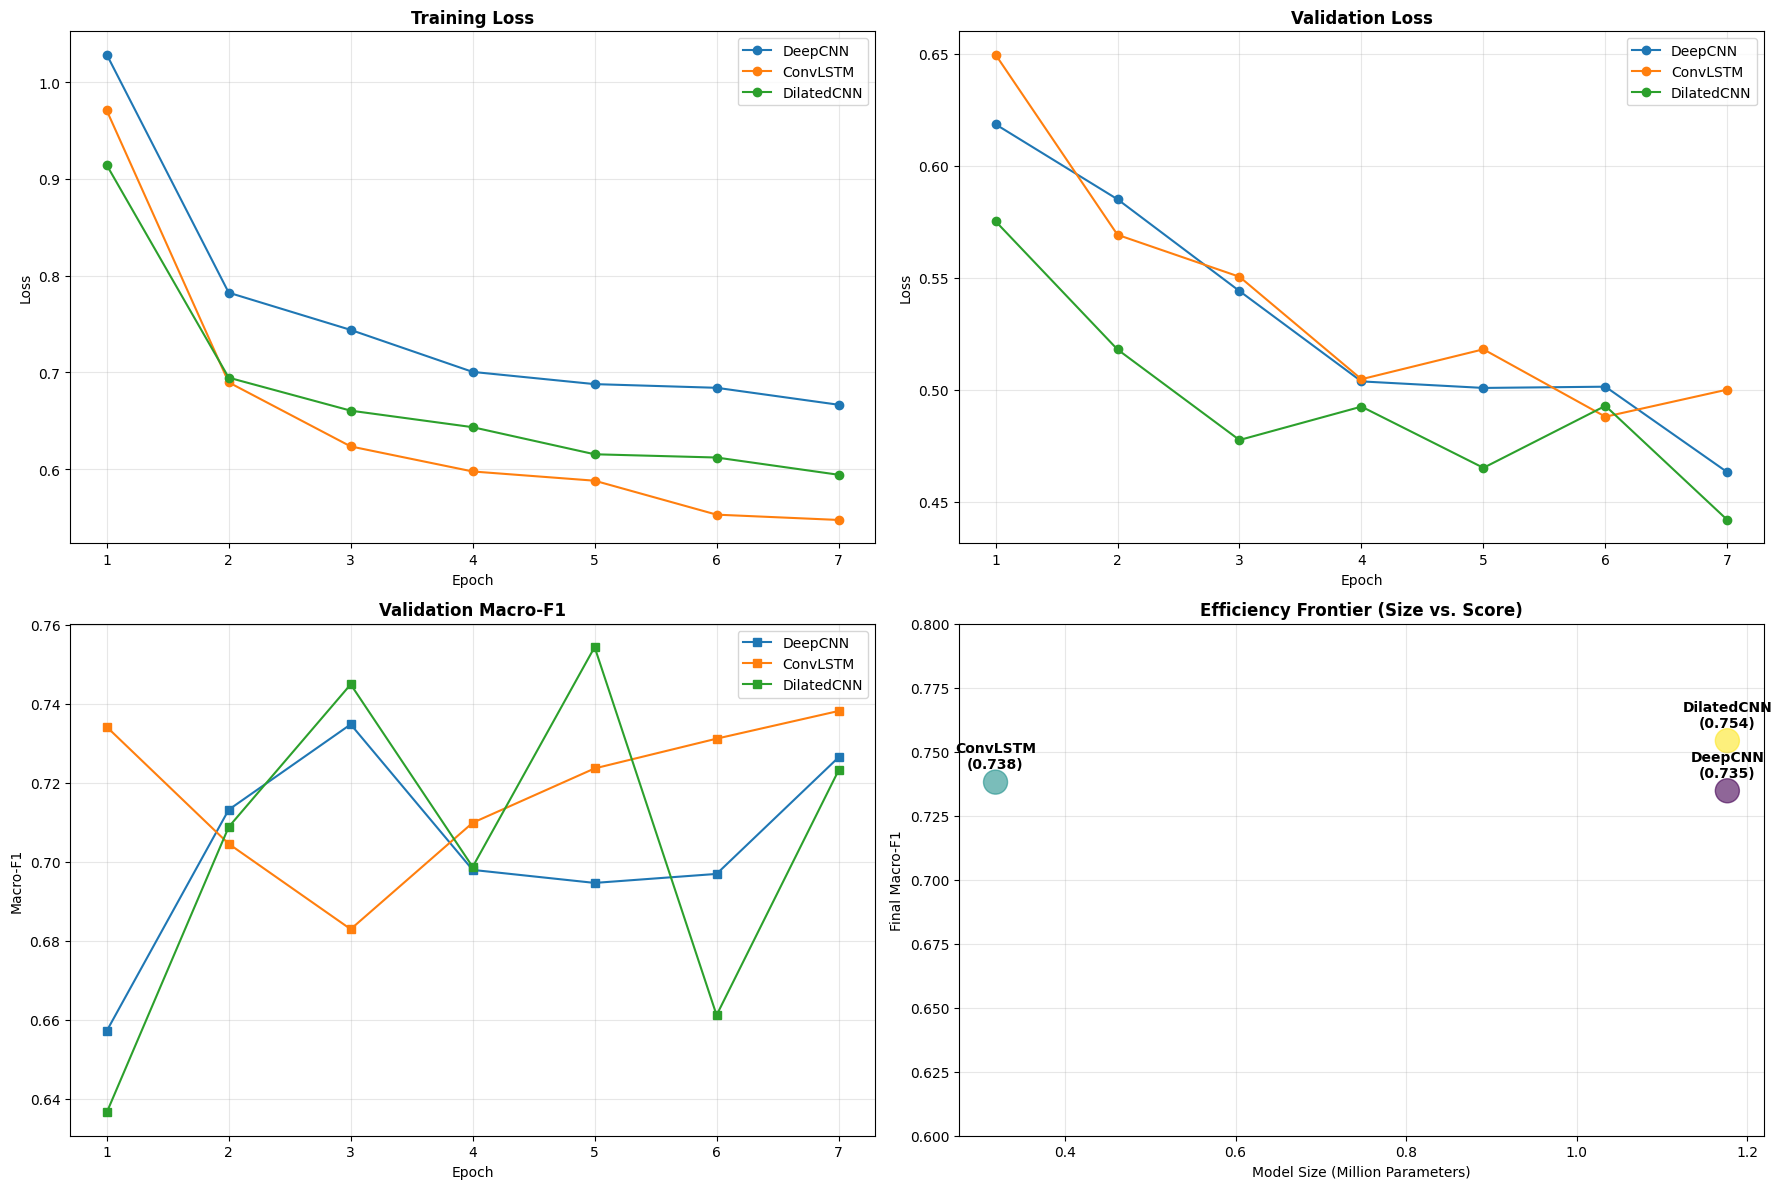

In [ ]:
# ====================================================================
# 1. FIX THE RESULTS DICTIONARY
# ====================================================================
# We need to ensure every model in 'results' has the keys the plotter expects.

for name, data in results.items():
    # A. Fix Key Mismatches (Parameters -> total_params)
    if 'Parameters' in data:
        data['total_params'] = data['Parameters']
    if 'F1' in data:
        data['final_macro_f1'] = data['F1']
        
    # B. Fill Missing Parameter Counts (for Recovered models)
    if 'total_params' not in data:
        # Instantiate a dummy model to count parameters
        if name == 'DeepCNN':
            dummy = DeepAvalancheNet(INPUT_CHANNELS, 5)
        elif name == 'ConvLSTM':
            dummy = AvalancheConvLSTM(INPUT_CHANNELS, 5)
        elif name == 'DilatedCNN':
            dummy = DilatedAvalancheNet(INPUT_CHANNELS, 5)
            
        params = sum(p.numel() for p in dummy.parameters())
        data['total_params'] = params
        data['final_macro_f1'] = data.get('F1', 0) # Ensure F1 exists
        
    # C. Handle Missing History (Create empty lists if they don't exist)
    if 'train_losses' not in data:
        data['train_losses'] = []
        data['val_losses'] = []
        data['val_macro_f1s'] = []

# ====================================================================
# 2. ROBUST PLOTTING CODE
# ====================================================================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# A. Curves (Only plot if history exists)
for arch_name, metrics in results.items():
    if len(metrics['train_losses']) > 0:
        epochs = range(1, len(metrics['train_losses']) + 1)
        ax1.plot(epochs, metrics['train_losses'], label=arch_name, marker='o')
        ax2.plot(epochs, metrics['val_losses'], label=arch_name, marker='o')
        ax3.plot(epochs, metrics['val_macro_f1s'], label=arch_name, marker='s')
    else:
        print(f"ℹ️ Skipping curves for {arch_name} (Recovered from file, no history)")

# Style for Curves
for ax, title, ylabel in zip([ax1, ax2, ax3], 
                           ['Training Loss', 'Validation Loss', 'Validation Macro-F1'],
                           ['Loss', 'Loss', 'Macro-F1']):
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, alpha=0.3)

# B. Scatter Plot (Model Size vs Performance) - This will now work for ALL
arch_names = list(results.keys())
params = [results[a]['total_params'] / 1e6 for a in arch_names] # Millions
f1s = [results[a]['final_macro_f1'] for a in arch_names]

scatter = ax4.scatter(params, f1s, s=300, alpha=0.6, c=range(len(arch_names)), cmap='viridis')

for i, name in enumerate(arch_names):
    ax4.annotate(f"{name}\n({f1s[i]:.3f})", (params[i], f1s[i]), 
                xytext=(0, 10), textcoords='offset points', ha='center', fontweight='bold')

ax4.set_xlabel('Model Size (Million Parameters)')
ax4.set_ylabel('Final Macro-F1')
ax4.set_title('Efficiency Frontier (Size vs. Score)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0.6, 0.8) # Zoom in to relevant F1 range

plt.tight_layout()
plt.savefig('experiments/week1_training_curves.png')
plt.show()

## **5.3 Hyperparameter Tuning**

In [15]:
# 1. Identify the Winner from Phase 2
print(f"Tuning Best Architecture: {best_arch_name.upper()}\n")

# Map name to class
arch_map = {
    'DeepCNN': DeepAvalancheNet,
    'ConvLSTM': AvalancheConvLSTM,
    'DilatedCNN': DilatedAvalancheNet
}
BestArchClass = arch_map[best_arch_name]

# 2. Define Tuning Trials
# We test:
#   A. Base LR (1e-4) + CrossEntropy (Control)
#   B. Low LR (1e-5) + CrossEntropy (Fine-tuning)
#   C. Base LR (1e-4) + Focal Loss (Handling Imbalance)

# Loss Functions
criterion_ce = nn.CrossEntropyLoss(weight=final_weights).to(device)
criterion_fl = FocalLoss(alpha=final_weights, gamma=2.0).to(device)

trials = [
    {'name': 'Base_CE',   'lr': 1e-4, 'loss_fn': criterion_ce, 'loss_name': 'CrossEntropy'},
    {'name': 'LowLR_CE',  'lr': 1e-5, 'loss_fn': criterion_ce, 'loss_name': 'CrossEntropy'},
    {'name': 'Base_Focal','lr': 1e-4, 'loss_fn': criterion_fl, 'loss_name': 'FocalLoss'}
]

tuning_results = {}
TUNING_EPOCHS = 4 # Short run to see impact

print("Hyperparameter & Loss Tuning")

for trial in trials:
    run_id = f"{best_arch_name}_{trial['name']}"
    
    # Instantiate Fresh Model
    model = BestArchClass(in_channels=len(dynamic_features)+4, num_classes=5).to(device)
    
    # Train using our engine
    metrics = train_model_engine(
        model_name=run_id,
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=trial['loss_fn'],
        epochs=TUNING_EPOCHS
    )
    
    # Store extended info
    tuning_results[run_id] = {
        **metrics,
        'lr': trial['lr'],
        'loss_name': trial['loss_name']
    }

/tmp/ipykernel_20/3761922915.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Tuning Best Architecture: DILATEDCNN

Hyperparameter & Loss Tuning

Training: DilatedCNN_Base_CE


Epoch 1/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss 0.8762 | Val Loss 0.5325 | F1 0.7214 | DL4 Recall 0.7044
New Best Model Saved! (F1: 0.7214)


Epoch 2/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Train Loss 0.6973 | Val Loss 0.4766 | F1 0.7314 | DL4 Recall 0.8955
New Best Model Saved! (F1: 0.7314)


Epoch 3/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Train Loss 0.6494 | Val Loss 0.5628 | F1 0.7242 | DL4 Recall 0.8833


Epoch 4/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_20/3761922915.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 4: Train Loss 0.6294 | Val Loss 0.4835 | F1 0.7404 | DL4 Recall 0.8846
New Best Model Saved! (F1: 0.7404)

Training: DilatedCNN_LowLR_CE


Epoch 1/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss 0.9095 | Val Loss 0.5733 | F1 0.6430 | DL4 Recall 0.9209
New Best Model Saved! (F1: 0.6430)


Epoch 2/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Train Loss 0.7050 | Val Loss 0.5541 | F1 0.6796 | DL4 Recall 0.9374
New Best Model Saved! (F1: 0.6796)


Epoch 3/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Train Loss 0.6588 | Val Loss 0.5087 | F1 0.7334 | DL4 Recall 0.8436
New Best Model Saved! (F1: 0.7334)


Epoch 4/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_20/3761922915.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 4: Train Loss 0.6327 | Val Loss 0.5257 | F1 0.7299 | DL4 Recall 0.8760

Training: DilatedCNN_Base_Focal


Epoch 1/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss 0.0735 | Val Loss 0.0450 | F1 0.5672 | DL4 Recall 0.9705
New Best Model Saved! (F1: 0.5672)


Epoch 2/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Train Loss 0.0458 | Val Loss 0.0360 | F1 0.5939 | DL4 Recall 0.9832
New Best Model Saved! (F1: 0.5939)


Epoch 3/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Train Loss 0.0411 | Val Loss 0.0348 | F1 0.6319 | DL4 Recall 0.9659
New Best Model Saved! (F1: 0.6319)


Epoch 4/4:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4: Train Loss 0.0375 | Val Loss 0.0344 | F1 0.5587 | DL4 Recall 0.9957



Best Configuration: DilatedCNN_Base_CE
   F1: 0.7404
   DL4 Recall: 0.8846
   Saved to: experiments/best_DilatedCNN_Base_CE.pth


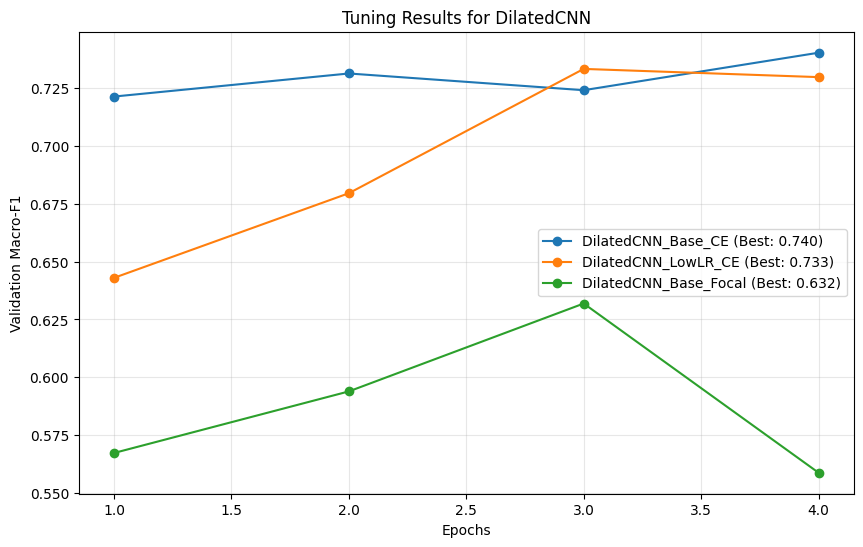

In [16]:
# Best Configuration
# 1. Find the best run based on Macro-F1
best_run_name = max(tuning_results.items(), key=lambda x: x[1]['F1'])[0]
best_metrics = tuning_results[best_run_name]

# 2. Define the 'best_config' dictionary for the Final Training cell
best_config = {
    'lr': best_metrics['lr'],
    'loss_name': best_metrics['loss_name'],
    # Map the string name back to the actual loss object we defined earlier
    'loss_obj': criterion_fl if best_metrics['loss_name'] == 'FocalLoss' else criterion_ce
}

print(f"\nBest Configuration: {best_run_name}")
print(f"   F1: {best_metrics['F1']:.4f}")
print(f"   DL4 Recall: {best_metrics['DL4_Recall']:.4f}")
print(f"   Saved to: experiments/best_{best_run_name}.pth")

# Simple Plot
fig, ax = plt.subplots(figsize=(10, 6))
for name, res in tuning_results.items():
    epochs = range(1, len(res['val_macro_f1s']) + 1)
    ax.plot(epochs, res['val_macro_f1s'], label=f"{name} (Best: {res['F1']:.3f})", marker='o')

ax.set_title(f"Tuning Results for {best_arch_name}")
ax.set_xlabel("Epochs")
ax.set_ylabel("Validation Macro-F1")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## **5.4 Final Training & Evaluation**

In [17]:
FINAL_ARCH_CLASS = arch_map[best_arch_name]
FINAL_LR = best_config['lr']
FINAL_CRITERION = best_config['loss_obj'] # Reuse the exact loss object from tuning
FINAL_EPOCHS = 15
INPUT_CHANNELS = len(dynamic_features) + 4

print(f"STARTING FINAL TRAINING")
print(f"   Model: {FINAL_ARCH_CLASS.__name__}")
print(f"   Loss: {best_config['loss_name']}")
print(f"   LR: {FINAL_LR}")


STARTING FINAL TRAINING
   Model: DilatedAvalancheNet
   Loss: CrossEntropy
   LR: 0.0001


In [18]:
# 2. Final Training
final_model = FINAL_ARCH_CLASS(in_channels=INPUT_CHANNELS, num_classes=5).to(device)

# Re-use our engine
final_metrics = train_model_engine(
    model_name="FINAL_MODEL",
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=FINAL_CRITERION,
    epochs=FINAL_EPOCHS
)

/tmp/ipykernel_20/3761922915.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Training: FINAL_MODEL


Epoch 1/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss 0.8808 | Val Loss 0.5689 | F1 0.6638 | DL4 Recall 0.8716
New Best Model Saved! (F1: 0.6638)


Epoch 2/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2: Train Loss 0.7044 | Val Loss 0.6799 | F1 0.7233 | DL4 Recall 0.7677
New Best Model Saved! (F1: 0.7233)


Epoch 3/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3: Train Loss 0.6612 | Val Loss 0.5251 | F1 0.6811 | DL4 Recall 0.8836


Epoch 4/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4: Train Loss 0.6265 | Val Loss 0.7858 | F1 0.5456 | DL4 Recall 0.9700


Epoch 5/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5: Train Loss 0.6200 | Val Loss 0.4477 | F1 0.7108 | DL4 Recall 0.9583


Epoch 6/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6: Train Loss 0.6107 | Val Loss 0.4708 | F1 0.7266 | DL4 Recall 0.9178
New Best Model Saved! (F1: 0.7266)


Epoch 7/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7: Train Loss 0.5934 | Val Loss 0.4839 | F1 0.7711 | DL4 Recall 0.7334
New Best Model Saved! (F1: 0.7711)


Epoch 8/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8: Train Loss 0.5763 | Val Loss 0.5443 | F1 0.7575 | DL4 Recall 0.7315


Epoch 9/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9: Train Loss 0.5771 | Val Loss 0.5488 | F1 0.6406 | DL4 Recall 0.9567


Epoch 10/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10: Train Loss 0.5743 | Val Loss 0.4936 | F1 0.7437 | DL4 Recall 0.7926


Epoch 11/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11: Train Loss 0.5621 | Val Loss 0.4540 | F1 0.7462 | DL4 Recall 0.8859


Epoch 12/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12: Train Loss 0.5255 | Val Loss 0.4351 | F1 0.7429 | DL4 Recall 0.9216


Epoch 13/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13: Train Loss 0.5252 | Val Loss 0.4275 | F1 0.7420 | DL4 Recall 0.9230


Epoch 14/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14: Train Loss 0.5177 | Val Loss 0.4579 | F1 0.7439 | DL4 Recall 0.8921


Epoch 15/15:   0%|          | 0/783 [00:00<?, ?it/s]/tmp/ipykernel_20/3761922915.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15: Train Loss 0.5175 | Val Loss 0.4343 | F1 0.7409 | DL4 Recall 0.9172
